# Soft-VAE

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random
from sklearn.metrics import roc_curve, auc
from datetime import datetime

import seaborn as sns
sns.set(style="ticks")

%matplotlib inline

### Parameters

In [7]:
# dataset_path = '/pio/lscratch/1/i279076/Medical/small-medical-22.h5'
dataset_path = '/home/ath0m/Desktop/small-medical-22.h5'

batch_size = 1024
num_workers = 4
z_dim = 100
lr = 0.001
log_interval = 50
epochs = 2
save_model = False

hyperdash = False
name = "Soft-VAE"

### Data loader

In [8]:
import h5py

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [9]:
class SmallMedicalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label


class SmallMedicalLoader:
    def __init__(self, dataset_path, batch_size, num_workers=8, pin_memory=True):
        self.dataset_path = dataset_path
        self.loader_args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

        with h5py.File(self.dataset_path, 'r') as f:
            self.train_images = f['train']['images'][...]
            self.train_labels = f['train']['labels'][...]

            self.test_images = f['test']['images'][...]
            self.test_labels = f['test']['labels'][...]

        self.train_dataset = SmallMedicalDataset(self.train_images, self.train_labels)
        self.test_dataset = SmallMedicalDataset(self.test_images, self.test_labels)

    def train_loader(self):
        return DataLoader(self.train_dataset, **self.loader_args)

    def test_loader(self):
        return DataLoader(self.test_dataset, shuffle=True, **self.loader_args)
    
    def test_loader_no_shfl(self):
        return DataLoader(self.test_dataset, shuffle=False, **self.loader_args)

In [10]:
loader = SmallMedicalLoader(dataset_path, batch_size)

train_loader = loader.train_loader()
test_loader = loader.test_loader()
test_loader_no_shfl = loader.test_loader_no_shfl()

### Model prototype

In [11]:
class PrototypeSVAE(nn.Module):
    def __init__(self, z_dim=60):
        super().__init__()

        self.z_dim = z_dim

        self.fc1  = nn.Linear(22**2, 400)
        self.fc21 = nn.Linear(400, self.z_dim)
        self.fc22 = nn.Linear(400, self.z_dim)
        self.fc3  = nn.Linear(self.z_dim, 400)
        self.fc4  = nn.Linear(400, 256 * 22**2)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        out = F.log_softmax(self.fc4(h3).reshape(-1, 256, 22, 22), dim=1)
        return out

    def forward(self, x):
        x = x[:, 1, :, :].view(-1, 22**2)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def NLL_loss(self, x, recon_x):
        return F.nll_loss(recon_x, (255 * x[:, 1, :, :]).long(), reduction='none').reshape(-1, 22 ** 2)
    
    def MSE_loss(self, x, recon_x):
        x = x[:, 1, :, :].reshape(-1, 22**2)
        return ((x - recon_x) ** 2)
    
    def KLD_loss(self, mu, logvar):
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        return (-0.5 * (1 + logvar - mu.pow(2) - logvar.exp()))
    
    def loss_function(self, x, recon_x, mu, logvar, extended=False):
        NLL = self.NLL_loss(x, recon_x).sum(1)
        KLD = self.KLD_loss(mu, logvar).sum(1)

        loss = NLL.sum() + KLD.sum()
        return (loss, NLL, KLD) if extended else loss

#### Model

In [24]:
model = PrototypeSVAE(z_dim=100).cuda()
model.load_state_dict(torch.load('/home/ath0m/Desktop/Medical/sonata2/cache/model_Soft-VAE_1.pth'))

model.eval()

PrototypeSVAE(
  (fc1): Linear(in_features=484, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=100, bias=True)
  (fc22): Linear(in_features=400, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=123904, bias=True)
)

### Playground

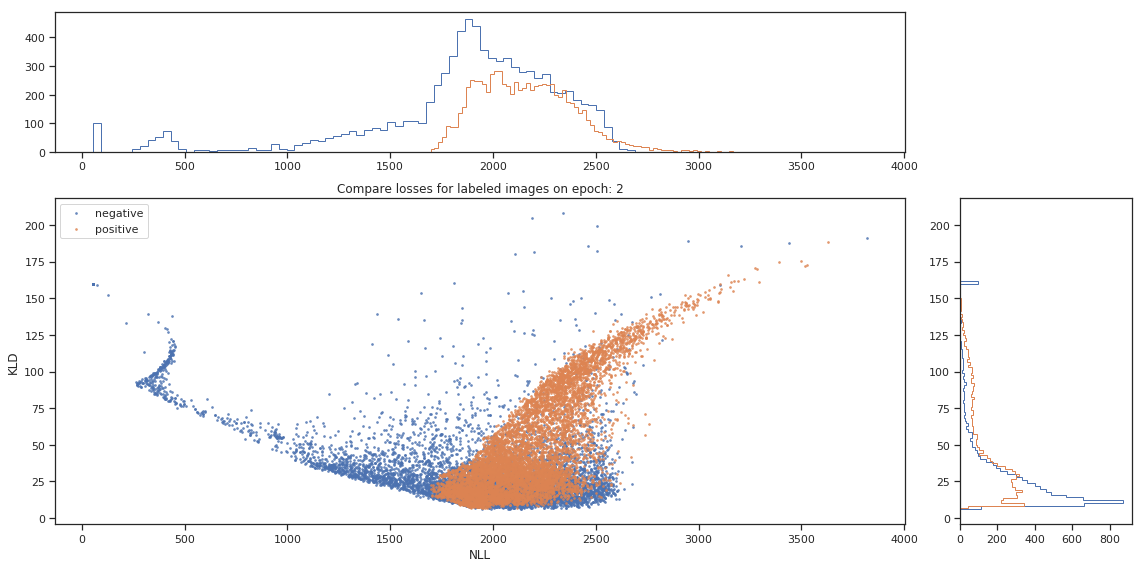

In [25]:
epoch = 2
samples = len(test_loader.dataset)
X, Y = np.zeros((3, samples)), np.zeros(samples)

with torch.no_grad():
    for i, (data, labels) in enumerate(test_loader):
        data = data.cuda()

        recon_data, mu, logvar = model(data)
        _, nll, kld = model.loss_function(data, recon_data, mu, logvar, extended=True)

        X[:, i * batch_size : i * batch_size + len(data)] = torch.stack([nll, kld, data[:, 1, :, :].reshape(-1, 22**2).sum(1)]).cpu()
        Y[i * batch_size : i * batch_size + len(data)] = labels

fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(3, 5)

ax_main = plt.subplot(gs[1:3, :4])
ax_xDist = plt.subplot(gs[0, :4], sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 4], sharey=ax_main)

for i, label in [(0, 'negative'), (1, 'positive')]:
    indices = (Y == i).nonzero()
    x, y = X[:2, indices].squeeze()
    ax_main.scatter(x, y, s=3, alpha=0.7, label=label)
    ax_xDist.hist(x, bins=100, histtype='step')
    ax_yDist.hist(y, bins=100, orientation='horizontal', histtype='step')

ax_main.set(xlabel="NLL", ylabel="KLD", title=f'Compare losses for labeled images on epoch: {epoch}')
ax_main.legend()

plt.tight_layout()
plt.show()

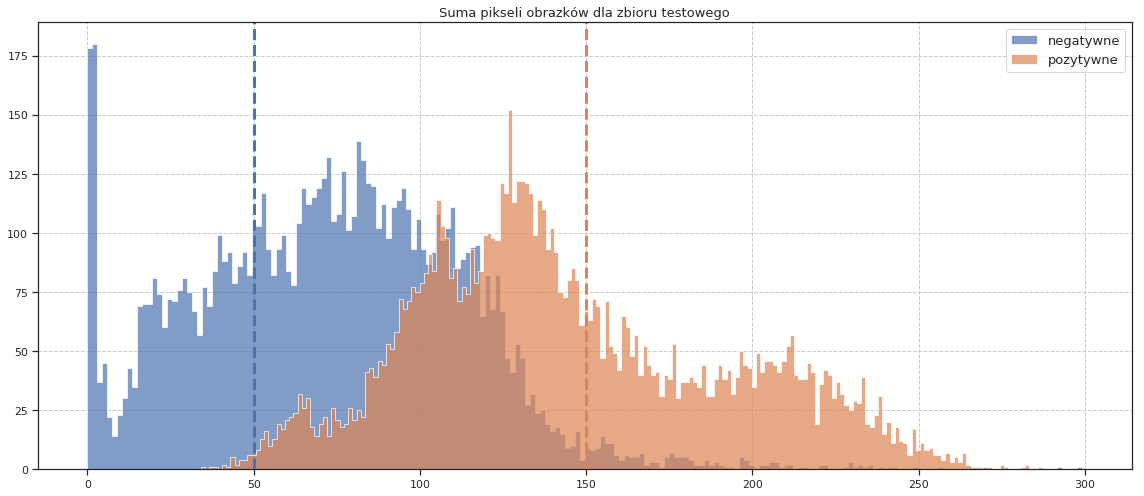

In [64]:
plt.figure(figsize=(16, 7))

for i, label in [(0, 'negatywne'), (1, 'pozytywne')]:
    indices = (Y == i).nonzero()
    x = X[2, indices].squeeze()
    plt.hist(x, bins=200, histtype='stepfilled', label=label, alpha=0.7)
    
plt.axvline(50, ls='--', lw=3.)
plt.axvline(150, ls='--', lw=3., color='#DD8452')

plt.grid(True, ls='--')
plt.title('Suma pikseli obrazków dla zbioru testowego', fontsize=13)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

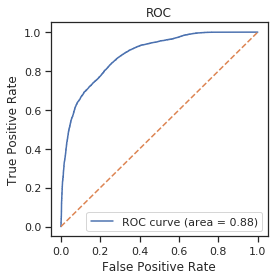

In [27]:
plt.figure(figsize=(4, 4))

cum_loss = X[2]
fpr, tpr, thresholds = roc_curve(Y, cum_loss)

area = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(area))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

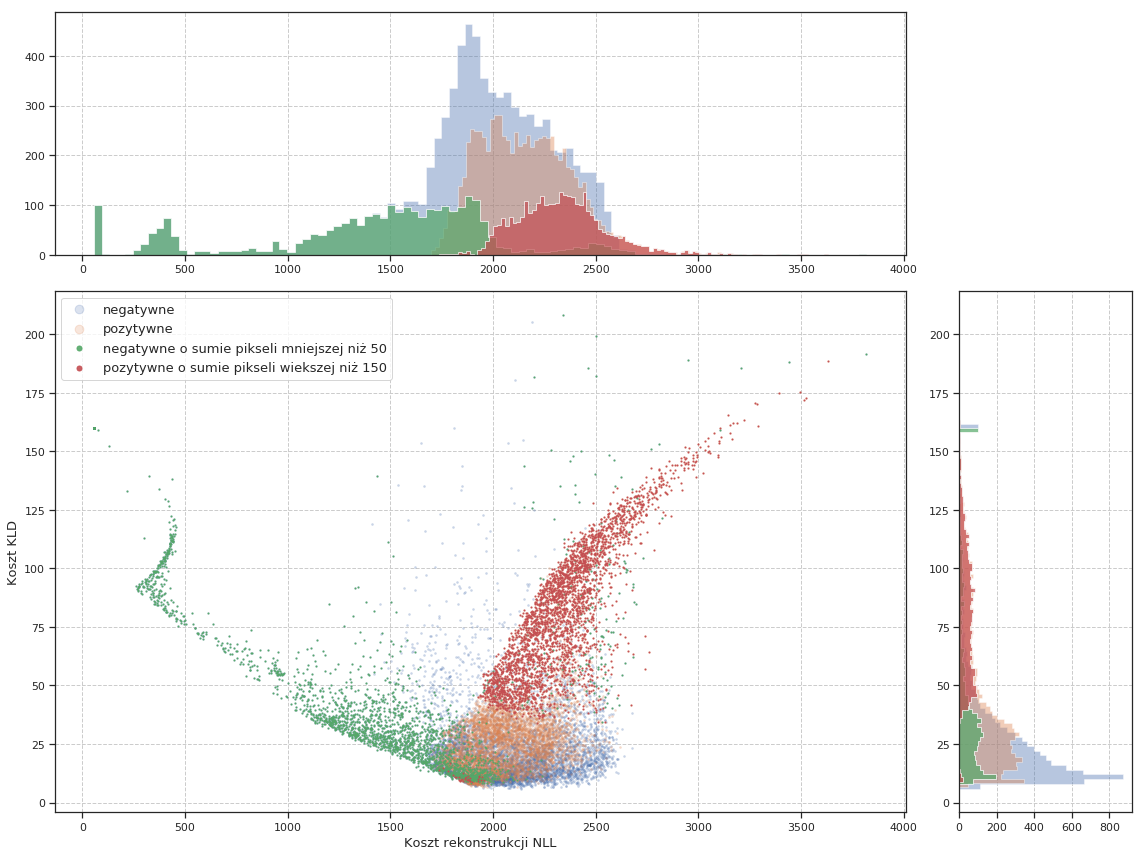

In [65]:
fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(3, 5)

ax_main = plt.subplot(gs[1:3, :4])
ax_xDist = plt.subplot(gs[0, :4], sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 4], sharey=ax_main)

ax_main.grid(True, ls='--')
ax_xDist.grid(True, ls='--')
ax_yDist.grid(True, ls='--')

above_th = 150
below_th = 50

for i, label in [(0, 'negatywne'), (1, 'pozytywne')]:
    indices = (Y == i).nonzero()
    x, y = X[:2, indices].squeeze()
    ax_main.scatter(x, y, s=3, alpha=0.2, label=label)
    ax_xDist.hist(x, bins=100, alpha=0.4, histtype='stepfilled')
    ax_yDist.hist(y, bins=100, alpha=0.4, orientation='horizontal', histtype='stepfilled')

for i, label in [(0, 'negatywne o sumie pikseli mniejszej niż 50'), (1, 'pozytywne o sumie pikseli wiekszej niż 150')]:
    X_label = X[:, (Y == i)].squeeze()
    indices = np.logical_or(X_label[2] > above_th, X_label[2] < below_th)
    x, y = X_label[:2, indices].squeeze()
    ax_main.scatter(x, y, s=4, alpha=0.9, marker='.', label=label)
    ax_xDist.hist(x, bins=100, histtype='stepfilled', alpha=0.7)
    ax_yDist.hist(y, bins=100, orientation='horizontal', histtype='stepfilled', alpha=0.7)

ax_main.set_xlabel("Koszt rekonstrukcji NLL", fontsize=13)
ax_main.set_ylabel("Koszt KLD", fontsize=13)
ax_main.legend(fontsize=13, markerscale=5)

plt.tight_layout()
plt.show()

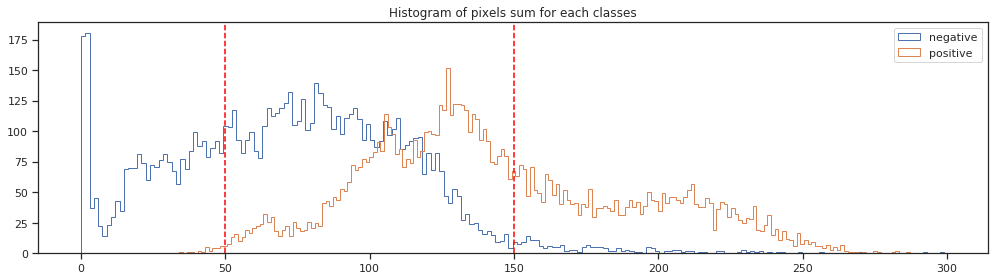

In [29]:
plt.figure(figsize=(14, 4))

for i, label in [(0, 'negative'), (1, 'positive')]:
    indices = (Y == i).nonzero()
    x = X[2, indices].squeeze()
    plt.hist(x, bins=200, histtype='step', label=label)
    
plt.axvline(below_th, c='red', ls='--')
plt.axvline(above_th, c='red', ls='--')

plt.title('Histogram of pixels sum for each classes')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
negative_below = []
positive_above = []

for image, label in loader.test_dataset:
    pixel_sum = image.flatten().sum()
    image = image.transpose(1, 2, 0)
    
    if pixel_sum <= below_th and label == 0.:
        negative_below.append(image)
    elif pixel_sum >= above_th and label == 1.:
        positive_above.append(image)

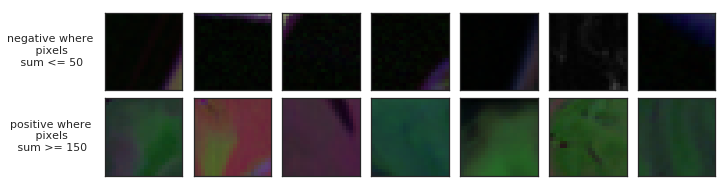

In [31]:
fig, axes = plt.subplots(2, 7, figsize=(11, 3))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for ax in axes.flat:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

for i in range(7):
    axes[0, i].imshow(random.choice(negative_below))
    axes[1, i].imshow(random.choice(positive_above))
        
for d, label in enumerate([f'negative where\n pixels\n sum <= {below_th}', 
                           f'positive where\n pixels\n sum >= {above_th}']):
    axes[d, 0].set_ylabel(label, rotation=0, fontsize=11)
    axes[d, 0].yaxis.set_label_coords(-0.7, 0.3)
    
# plt.tight_layout()
plt.show()

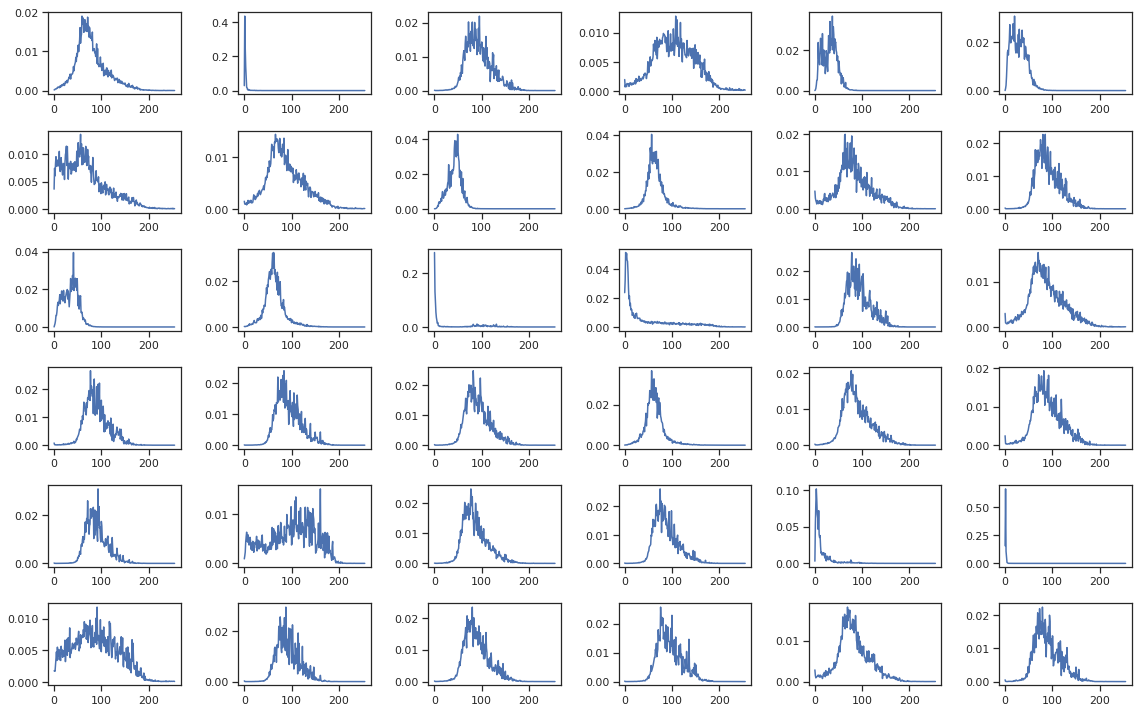

In [32]:
plt.figure(figsize=(16, 10))
ppbs = []

with torch.no_grad():
    for i, (data, labels) in enumerate(test_loader):
        data = data.cuda()

        recon_data, mu, logvar = model(data)
        
        for i in np.random.randint(1024, size=36):
            x, y = np.random.randint(22, size=2)
            ppb = recon_data[i, :, x, y].cpu().numpy()
            ppbs.append(ppb)
            
        break

for i, ppb in enumerate(ppbs, 1):
    plt.subplot(6, 6, i)
    plt.plot(np.exp(ppb))

plt.tight_layout()
plt.show()